# Lab 2: Regularization Comparison

This notebook compares different regularization techniques (L1, L2, ElasticNet) for Linear and Logistic Regression models.


In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Add src to path
sys.path.append('..')

from src.models.linear_regression import LinearRegression
from src.models.logistic_regression import LogisticRegression
from src.metrics.regression_metrics import RegressionMetrics
from src.metrics.classification_metrics import ClassificationMetrics
from src.data.preprocessing import preprocess_houses_data, preprocess_titanic_data


In [2]:
# Data will be loaded and preprocessed in the next cells
print("Loading and preprocessing datasets...")


Loading and preprocessing datasets...


In [3]:
# Dataset information
print("Datasets to be used:")
print("- California Houses: Regression task")
print("- Titanic: Classification task")


Datasets to be used:
- California Houses: Regression task
- Titanic: Classification task


In [4]:
# Preprocess California Houses dataset
X_houses_train, X_houses_test, y_houses_train, y_houses_test, feature_names_houses = preprocess_houses_data('../data/California_Houses.csv')

# Create validation split from training data
n_train = len(X_houses_train)
n_val = int(n_train * 0.2)  # 20% for validation
indices = torch.randperm(n_train)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

X_houses_val = X_houses_train[val_indices]
y_houses_val = y_houses_train[val_indices]
X_houses_train = X_houses_train[train_indices]
y_houses_train = y_houses_train[train_indices]

print(f"Houses dataset - Train: {X_houses_train.shape}, Val: {X_houses_val.shape}, Test: {X_houses_test.shape}")


Houses dataset - Train: torch.Size([13210, 24]), Val: torch.Size([3302, 24]), Test: torch.Size([4128, 24])


In [5]:
# Preprocess Titanic dataset
X_titanic_train, X_titanic_test, y_titanic_train, y_titanic_test, feature_names_titanic = preprocess_titanic_data('../data/Titanic-Dataset.csv')

# Create validation split from training data
n_train = len(X_titanic_train)
n_val = int(n_train * 0.2)  # 20% for validation
indices = torch.randperm(n_train)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

X_titanic_val = X_titanic_train[val_indices]
y_titanic_val = y_titanic_train[val_indices]
X_titanic_train = X_titanic_train[train_indices]
y_titanic_train = y_titanic_train[train_indices]

print(f"Titanic dataset - Train: {X_titanic_train.shape}, Val: {X_titanic_val.shape}, Test: {X_titanic_test.shape}")
print(f"Titanic target distribution: {torch.bincount(y_titanic_train.int())}")


Titanic dataset - Train: torch.Size([571, 15]), Val: torch.Size([142, 15]), Test: torch.Size([178, 15])
Titanic target distribution: tensor([356, 215])


## Linear Regression with Regularization


In [6]:
# Train Linear Regression models with different regularizations
linear_models = {}
reg_params = {
    'none': {'reg_type': 'none'},
    'l1': {'reg_type': 'l1', 'l1_lambda': 0.01},
    'l2': {'reg_type': 'l2', 'l2_lambda': 0.01},
    'elasticnet': {'reg_type': 'elasticnet', 'l1_lambda': 0.005, 'l2_lambda': 0.005, 'alpha': 0.5}
}

for name, params in reg_params.items():
    print(f"Training Linear Regression with {name} regularization...")
    model = LinearRegression(learning_rate=0.01, max_epochs=1000, **params)
    model.fit(X_houses_train, y_houses_train, X_houses_val, y_houses_val)
    linear_models[name] = model
    print(f"Final train MSE: {linear_models[name].history['train_loss'][-1]:.4f}")


Training Linear Regression with none regularization...


Final train MSE: 4291663360.0000
Training Linear Regression with l1 regularization...
Final train MSE: 4291663360.0000
Training Linear Regression with l2 regularization...
Final train MSE: 4304281600.0000
Training Linear Regression with elasticnet regularization...
Final train MSE: 4294483712.0000


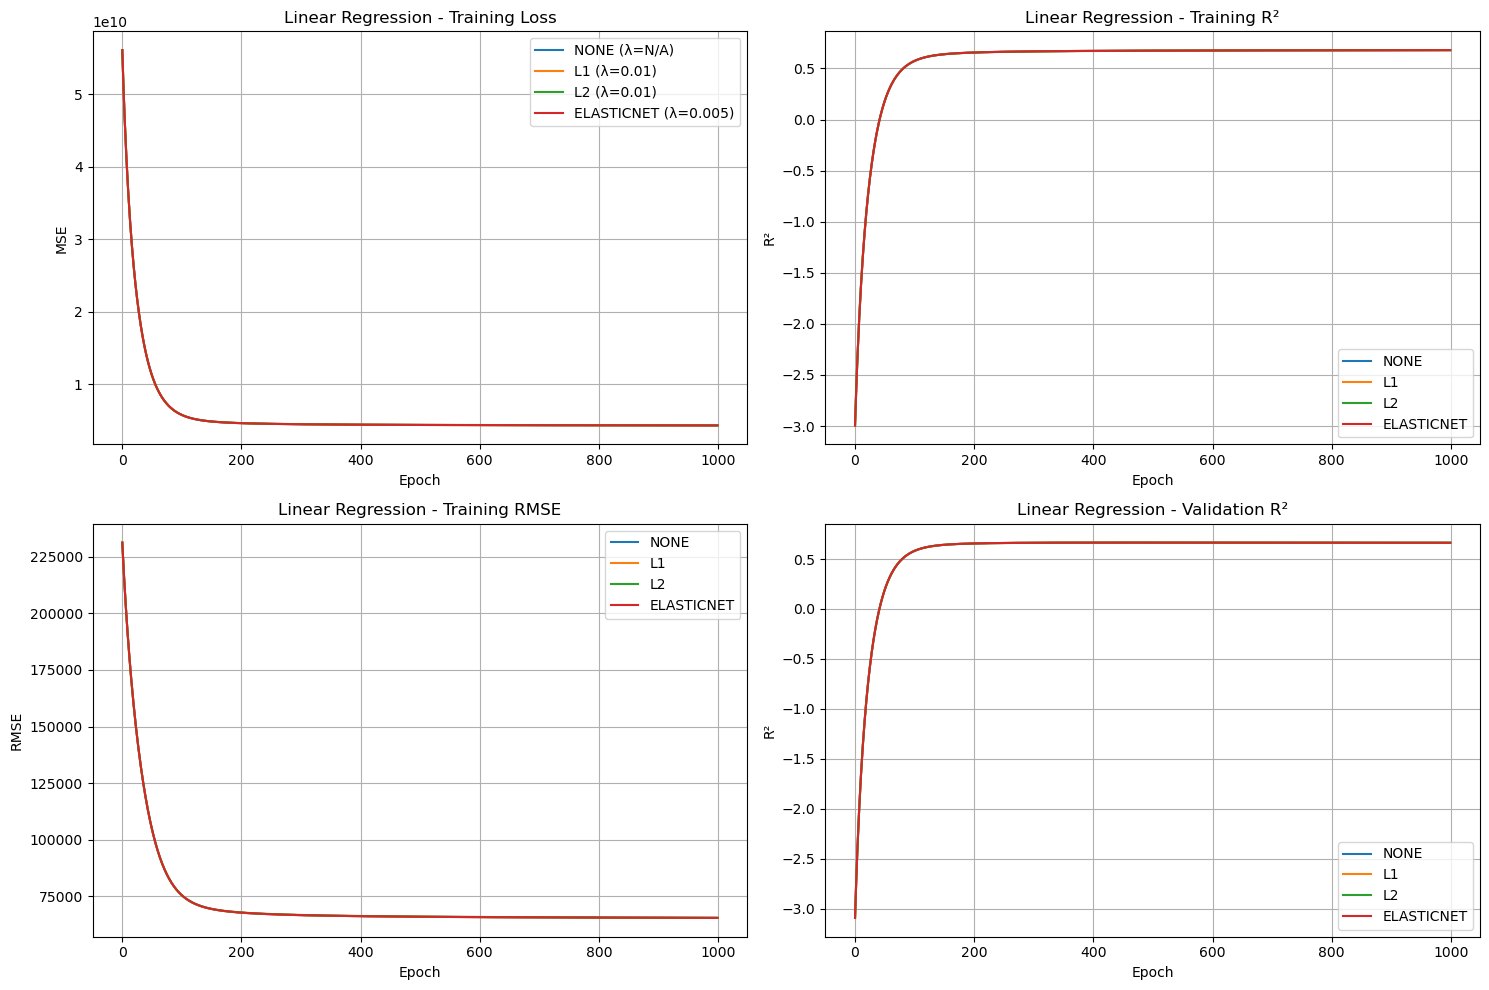

In [7]:
# Plot Linear Regression training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss
axes[0, 0].set_title('Linear Regression - Training Loss')
for name, model in linear_models.items():
    axes[0, 0].plot(model.history['train_loss'], label=f'{name.upper()} (λ={reg_params[name].get("l1_lambda", reg_params[name].get("l2_lambda", "N/A"))})')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Training R²
axes[0, 1].set_title('Linear Regression - Training R²')
for name, model in linear_models.items():
    r2_values = [metrics['r2'] for metrics in model.history['train_metrics']]
    axes[0, 1].plot(r2_values, label=f'{name.upper()}')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('R²')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Training RMSE
axes[1, 0].set_title('Linear Regression - Training RMSE')
for name, model in linear_models.items():
    rmse_values = [metrics['rmse'] for metrics in model.history['train_metrics']]
    axes[1, 0].plot(rmse_values, label=f'{name.upper()}')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Validation R²
axes[1, 1].set_title('Linear Regression - Validation R²')
for name, model in linear_models.items():
    if model.history['val_metrics']:
        val_r2_values = [metrics['r2'] for metrics in model.history['val_metrics']]
        axes[1, 1].plot(val_r2_values, label=f'{name.upper()}')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('R²')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## Logistic Regression with Regularization


In [8]:
# Helper functions for logistic regression comparison
def _ensure_binary(y: torch.Tensor) -> torch.Tensor:
    if y.dim() == 1: 
        y = y.view(-1, 1)
    yv = y.view(-1).float()
    uniq = torch.unique(yv)
    if torch.all((uniq == 0) | (uniq == 1)):
        return y.float()
    if torch.all((uniq == -1) | (uniq == 1)):
        return (y > 0).float()
    raise ValueError(f"y must be binary {{0,1}} (or {{-1,1}}), got uniques: {uniq.tolist()}")

def _plot_compare(histories: dict[str, dict], key: str, title: str, ylabel: str):
    plt.figure(figsize=(8, 5))
    for name, hist in histories.items():
        if key in hist and len(hist[key]) > 0:
            plt.plot(hist[key], label=name)
    plt.xlabel("epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Wrapper class to adapt existing LogisticRegression to the comparison interface
class LogisticRegWrapper:
    def __init__(self, n_features, lr=1e-2, init_std=1e-2, seed=42, reg=None, alpha=0.0, l1_ratio=0.5):
        torch.manual_seed(seed)
        self.reg = reg
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        
        # Map to existing LogisticRegression parameters
        if reg == "l1":
            reg_type = "l1"
            l1_lambda = alpha
            l2_lambda = 0.0
        elif reg == "l2":
            reg_type = "l2"
            l1_lambda = 0.0
            l2_lambda = alpha
        elif reg == "elasticnet":
            reg_type = "elasticnet"
            l1_lambda = alpha * l1_ratio
            l2_lambda = alpha * (1 - l1_ratio)
        else:
            reg_type = "none"
            l1_lambda = 0.0
            l2_lambda = 0.0
            
        self.model = LogisticRegression(
            learning_rate=lr, 
            max_epochs=300, 
            reg_type=reg_type,
            l1_lambda=l1_lambda,
            l2_lambda=l2_lambda,
            alpha=l1_ratio
        )
        self.history = {}
        
    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=300, thresh=0.5, print_every=10**9):
        y_train = _ensure_binary(y_train)
        if X_val is not None and y_val is not None:
            y_val = _ensure_binary(y_val)
            
        self.model.max_epochs = epochs
        self.model.fit(X_train, y_train, X_val, y_val)
        
        # Convert history to the expected format
        self.history = {
            "train_loss": self.model.history['train_loss'],
            "val_loss": [],
            "val_acc": [],
            "val_f1": []
        }
        
        if self.model.history['val_metrics']:
            for metrics in self.model.history['val_metrics']:
                self.history["val_loss"].append(self.model._bce_loss(y_val, self.model.predict_proba(X_val)).item())
                self.history["val_acc"].append(metrics['accuracy'].item())
                self.history["val_f1"].append(metrics['f1'].item())

def compare_logreg_regularizers(
    X_train, y_train, X_val=None, y_val=None,
    *, epochs=300, lr=1e-2, alpha=1e-3, l1_ratio=0.5, seed=42, thresh=0.5
):
    y_train = _ensure_binary(y_train)
    if X_val is not None and y_val is not None:
        y_val = _ensure_binary(y_val)

    n_features = X_train.shape[1]
    variants = {
        "No reg":                         dict(reg=None,         alpha=0.0,   l1_ratio=l1_ratio),
        f"L2 λ={alpha:g}":                dict(reg="l2",         alpha=alpha, l1_ratio=l1_ratio),
        f"L1 λ={alpha:g}":                dict(reg="l1",         alpha=alpha, l1_ratio=l1_ratio),
        f"ElasticNet λ={alpha:g}, ρ={l1_ratio:g}":
                                         dict(reg="elasticnet", alpha=alpha, l1_ratio=l1_ratio),
    }

    histories, models = {}, {}
    for name, cfg in variants.items():
        print(f"Training {name}...")
        m = LogisticRegWrapper(
            n_features=n_features, lr=lr, init_std=1e-2, seed=seed,
            reg=cfg["reg"], alpha=cfg["alpha"], l1_ratio=cfg["l1_ratio"]
        )
        m.fit(X_train, y_train, X_val=X_val, y_val=y_val,
              epochs=epochs, thresh=thresh, print_every=10**9)
        histories[name] = m.history
        models[name] = m

    _plot_compare(histories, "train_loss", "Train BCE (data only)", "BCE")
    if X_val is not None and y_val is not None:
        _plot_compare(histories, "val_loss",   "Val BCE (data only)", "BCE")
        _plot_compare(histories, "val_acc",    "Val Accuracy",        "Accuracy")
        _plot_compare(histories, "val_f1",     "Val F1",              "F1")
    
    return models, histories

# Run the comparison
logistic_models, logistic_histories = compare_logreg_regularizers(
    X_titanic_train, y_titanic_train, X_titanic_val, y_titanic_val,
    epochs=300, lr=1e-2, alpha=1e-3, l1_ratio=0.5, seed=42, thresh=0.5
)


Training No reg...


RuntimeError: The size of tensor a (15) must match the size of tensor b (571) at non-singleton dimension 1

## Final Performance Comparison


In [ ]:
# Test performance comparison for Linear Regression
print("=== Linear Regression Test Performance ===")
for name, model in linear_models.items():
    test_metrics = model.score(X_houses_test, y_houses_test)
    print(f"{name.upper()}:")
    print(f"  MSE: {test_metrics['mse']:.4f}")
    print(f"  RMSE: {test_metrics['rmse']:.4f}")
    print(f"  R²: {test_metrics['r2']:.4f}")
    print()


=== Linear Regression Test Performance ===
NONE:
  MSE: 4384084992.0000
  RMSE: 66212.4219
  R²: 0.6725

L1:
  MSE: 4384085504.0000
  RMSE: 66212.4297
  R²: 0.6725

L2:
  MSE: 4393485312.0000
  RMSE: 66283.3750
  R²: 0.6718

ELASTICNET:
  MSE: 4386093056.0000
  RMSE: 66227.5859
  R²: 0.6723



In [ ]:
# Test performance comparison for Logistic Regression
print("=== Logistic Regression Test Performance ===")
for name, model in logistic_models.items():
    test_metrics = model.model.score(X_titanic_test, y_titanic_test)
    print(f"{name}:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  Precision: {test_metrics['precision']:.4f}")
    print(f"  Recall: {test_metrics['recall']:.4f}")
    print(f"  F1 Score: {test_metrics['f1_score']:.4f}")
    print()


In [ ]:
# Test performance comparison for Logistic Regression
print("=== Logistic Regression Test Performance ===")
for name, model in logistic_models.items():
    test_metrics = model.score(X_titanic_test, y_titanic_test)
    print(f"{name.upper()}:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  Precision: {test_metrics['precision']:.4f}")
    print(f"  Recall: {test_metrics['recall']:.4f}")
    print(f"  F1 Score: {test_metrics['f1_score']:.4f}")
    print()


=== Logistic Regression Test Performance ===
NONE:
  Accuracy: 0.4045
  Precision: 0.4045
  Recall: 1.0000
  F1 Score: 0.5760

L1:
  Accuracy: 0.6966
  Precision: 0.7500
  Recall: 0.3750
  F1 Score: 0.5000

L2:
  Accuracy: 0.4045
  Precision: 0.4045
  Recall: 1.0000
  F1 Score: 0.5760

ELASTICNET:
  Accuracy: 0.7697
  Precision: 0.6867
  Recall: 0.7917
  F1 Score: 0.7355



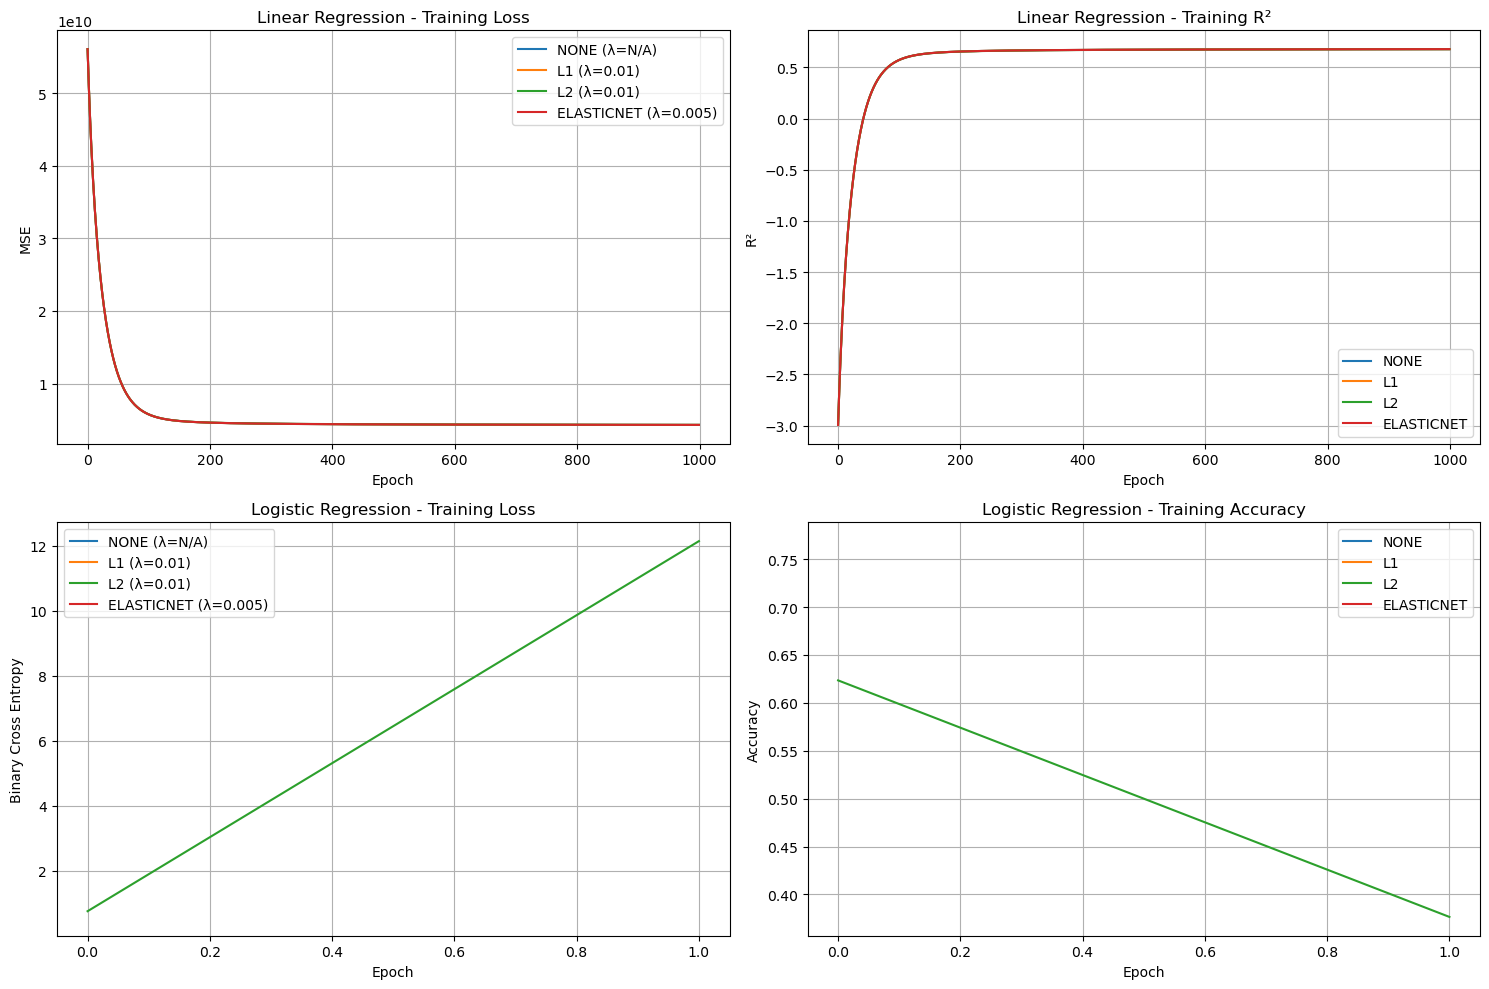

Regularization comparison plot saved to output/regularization_comparison.png


In [ ]:
# Save plots to output directory
import os
os.makedirs('output', exist_ok=True)

# Save the regularization comparison plots
plt.figure(figsize=(15, 10))

# Linear Regression plots
plt.subplot(2, 2, 1)
plt.title('Linear Regression - Training Loss')
for name, model in linear_models.items():
    plt.plot(model.history['train_loss'], label=f'{name.upper()} (λ={reg_params[name].get("l1_lambda", reg_params[name].get("l2_lambda", "N/A"))})')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Linear Regression - Training R²')
for name, model in linear_models.items():
    r2_values = [metrics['r2'] for metrics in model.history['train_metrics']]
    plt.plot(r2_values, label=f'{name.upper()}')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Logistic Regression - Training Loss')
for name, model in logistic_models.items():
    plt.plot(model.history['train_loss'], label=f'{name.upper()} (λ={reg_params[name].get("l1_lambda", reg_params[name].get("l2_lambda", "N/A"))})')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Logistic Regression - Training Accuracy')
for name, model in logistic_models.items():
    acc_values = [metrics['accuracy'] for metrics in model.history['train_metrics']]
    plt.plot(acc_values, label=f'{name.upper()}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('output/regularization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Regularization comparison plot saved to output/regularization_comparison.png")
